##### based on https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import tensorflow as tf

/home/key/software/anaconda3/envs/tf3.5/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tf.reset_default_graph()

### load MNIST

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


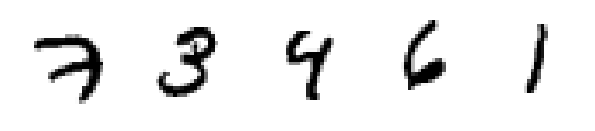

In [5]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [6]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

### Input

In [7]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")


### First conv layer

256 filters with a 9x9 kernel

output shape will be 20x20 because of no padding

In [8]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid", # = none
    "activation": tf.nn.relu,
}

conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv1

<tf.Tensor 'conv1/Relu:0' shape=(?, 20, 20, 256) dtype=float32>

### Second conv layer == Primary capsules

_The second layer (PrimaryCapsules) is a convolutional capsule layer with 32 channels of convolutional 8D capsules (i.e. each primary capsule contains 8 convolutional units with a 9 × 9 kernel and a stride of 2)._

- 32 primary capsules

- Each capsule contains 8 conv units so we have 32x8 = 256 conv units overall

- There are 32x6x6 = 1152 8d outputs

_In total PrimaryCapsules has [32×6×6] capsule outputs (each output is an 8D vector) and each capsule in the
[6×6] grid is sharing their weights with each other._

In [9]:
caps1_n_maps = 32 # primary capsules
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsule outputs
caps1_n_dims = 8  # conv units per capsule

In [10]:
conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)
conv2

<tf.Tensor 'conv2/Relu:0' shape=(?, 6, 6, 256) dtype=float32>

##### Reshape to (batch size, 6×6×32, 8) which is equivalent in this case to (batch size, 6×6×32, 8) (because primary capsules are fully connected to digit capsules)

In [11]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")
caps1_raw

<tf.Tensor 'caps1_raw:0' shape=(?, 1152, 8) dtype=float32>

##### Squash

_We therefore use a non-linear "squashing" function to ensure that short vectors get shrunk to almost zero length and long vectors get shrunk to a length slightly below 1._ 

$\operatorname{squash}(\mathbf{s}) = \dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$

In [12]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [13]:
caps1_output = squash(caps1_raw, name="caps1_output")
caps1_output

Instructions for updating:
keep_dims is deprecated, use keepdims instead


<tf.Tensor 'caps1_output/mul:0' shape=(?, 1152, 8) dtype=float32>

### Digit capsules

In [14]:
caps2_n_caps = 10
caps2_n_dims = 16

##### Step 1: Compute the Predicted Output Vectors

The transformation matrix $W_{ij}$ must transform from 8d to 16d and so, be of shape 16x8.

The code computes all predicted vectors for all combinations (i,j) at once, like this - but with one additional dimension, the batch dimension:

$
\pmatrix{
  \mathbf{W}_{1,1} & \mathbf{W}_{1,2} & \cdots & \mathbf{W}_{1,10} \\
  \mathbf{W}_{2,1} & \mathbf{W}_{2,2} & \cdots & \mathbf{W}_{2,10} \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{W}_{1152,1} & \mathbf{W}_{1152,2} & \cdots & \mathbf{W}_{1152,10}
} \times
\pmatrix{
  \mathbf{u}_1 & \mathbf{u}_1 & \cdots & \mathbf{u}_1 \\
  \mathbf{u}_2 & \mathbf{u}_2 & \cdots & \mathbf{u}_2 \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{u}_{1152} & \mathbf{u}_{1152} & \cdots & \mathbf{u}_{1152}
}
=
\pmatrix{
\hat{\mathbf{u}}_{1|1} & \hat{\mathbf{u}}_{2|1} & \cdots & \hat{\mathbf{u}}_{10|1} \\
\hat{\mathbf{u}}_{1|2} & \hat{\mathbf{u}}_{2|2} & \cdots & \hat{\mathbf{u}}_{10|2} \\
\vdots & \vdots & \ddots & \vdots \\
\hat{\mathbf{u}}_{1|1152} & \hat{\mathbf{u}}_{2|1152} & \cdots & \hat{\mathbf{u}}_{10|1152}
}
$



In [15]:
init_sigma = 0.1

#  this variable of shape (1, 1152, 10, 16, 8) will hold all the transformation matrices
W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")
W

<tf.Variable 'W:0' shape=(1, 1152, 10, 16, 8) dtype=float32_ref>

In [16]:
batch_size = tf.shape(X)[0]
# tile to work on batch
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")
W_tiled

<tf.Tensor 'W_tiled:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

In [17]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_expanded

<tf.Tensor 'caps1_output_expanded:0' shape=(?, 1152, 8, 1) dtype=float32>

In [18]:
# expand once per digit class
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tile

<tf.Tensor 'caps1_output_tile:0' shape=(?, 1152, 1, 8, 1) dtype=float32>

In [19]:
# and tile
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")
caps1_output_tiled

<tf.Tensor 'caps1_output_tiled:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

##### compute predicted output

In [20]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

### Routing by agreement

In [21]:
# raw routing weights
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")
raw_weights

<tf.Tensor 'raw_weights:0' shape=(?, 1152, 10, 1, 1) dtype=float32>

#### Round 1

##### compute softmax

$\mathbf{c}_{i} = \operatorname{softmax}(\mathbf{b}_i)$ 

In [22]:
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

Instructions for updating:
dim is deprecated, use axis instead


##### compute the weighted sum of all the predicted output vectors for each second-layer capsule,

$\mathbf{s}_j = \sum\limits_{i}{c_{i,j}\hat{\mathbf{u}}_{j|i}}$ 

* To perform elementwise matrix multiplication (also called the Hadamard product, noted $\circ$), we use the `tf.multiply()` function. It requires `routing_weights` and `caps2_predicted` to have the same rank, which is why we added two extra dimensions of size 1 to `routing_weights`, earlier.
* The shape of `routing_weights` is (_batch size_, 1152, 10, 1, 1) while the shape of `caps2_predicted` is (_batch size_, 1152, 10, 16, 1).  Since they don't match on the fourth dimension (1 _vs_ 16), `tf.multiply()` automatically _broadcasts_ the `routing_weights` 16 times along that dimension.

In [24]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")
weighted_sum

##### squash

In [26]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

#### Round 2